
# Hierarchical Risk Parity in Python

## Basic configuration

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

---
## Reading files

In [3]:
from os import listdir
import pandas as pd
import pickle
import numpy as np
import time
from os.path import isfile, join
onlyfiles = [f for f in listdir("Data/Stocks/") if isfile(join("Data/Stocks/", f))]
print(len(onlyfiles))
onlyfiles = onlyfiles[:20]

7195


In [4]:
df = pd.DataFrame()
for file_x in onlyfiles:
    try:
        to_remove = pd.read_csv('Data/Stocks/'+ file_x)
        if to_remove.shape[0] >= 501:
            df[file_x.replace('.txt','')] = ((to_remove.Close.iloc[1:501].values-to_remove.Close.iloc[:500].values)/to_remove.Close.iloc[:500].values)
    except:
        pass
print df.shape

(500, 16)


In [5]:
df.to_csv("Data/Exported/series.csv")
df.cov().to_csv("Data/Exported/cov.csv")
df.corr().to_csv("Data/Exported/corr.csv")

---
## HRP Model

In [6]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd 

In [7]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov) 
    ivp/=ivp.sum() 
    return ivp

def getClusterVar(cov,cItems):
    # Compute variance per cluster 
    cov_=cov.loc[cItems,cItems] # matrix slice 
    w_=getIVP(cov_).reshape(-1,1) 
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0] 
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int) 
    sortIx=pd.Series([link[-1,0],link[-1,1]]) 
    numItems=link[-1,3] # number of original items 
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space 
        df0=sortIx[sortIx>=numItems] # find clusters 
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1) 
        sortIx=sortIx.append(df0) # item 2 
        sortIx=sortIx.sort_index() # re-sort 
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()
#———————————————————————————————————————

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx)
    cItems=[sortIx] # initialize all items in one cluster 
    while len(cItems)>0:
        cItems=[i[j:k] for i in cItems for j,k in ((0,len(i)/2), \
                                               (len(i)/2,len(i))) if len(i)>1] # bi-section
        for i in xrange(0,len(cItems),2): # parse in pairs 
            cItems0=cItems[i] # cluster 1 
            cItems1=cItems[i+1] # cluster 2 
            cVar0=getClusterVar(cov,cItems0) 
            cVar1=getClusterVar(cov,cItems1) 
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2 
    return w
#———————————————————————————————————————

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1 # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist
#———————————————————————————————————————

def plotCorrMatrix(path,corr,labels=None): # Heatmap of the correlation matrix
    if labels is None:labels=[] 
    plt.pcolor(corr)
    plt.colorbar() 
    plt.yticks(np.arange(.5,corr.shape[0]+.5),labels) 
    plt.xticks(np.arange(.5,corr.shape[0]+.5),labels) 
    #plt.savefig(path)
    plt.show()
    plt.clf();plt.close() # reset pylab
    return

In [8]:
def plot(link):
    # calculate full dendrogram
    plt.figure(figsize=(25, 10))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('saplte index')
    plt.ylabel('distance')
    sch.dendrogram(
        link,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()

In [9]:
def main():
    cov,corr=df.cov(),df.corr()
    #2) compute and plot correl matrix 
    plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns) 
    
    #3) cluster
    dist=correlDist(corr)
    link=sch.linkage(dist,'single')
    plot(link)
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels 
    df0=corr.loc[sortIx,sortIx] # reorder 
    plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx) 
    return hrp, df0

---
# Markowitz

In [10]:
n_portfolios = 50000

In [11]:
returns_annual = ((df.mean() + 1) ** 250) - 1 # Correct formula
selected = df.columns

# get daily and covariance of returns of the stock
cov_daily = df.cov()
cov_annual = cov_daily * 250

In [12]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(selected)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    returns = np.dot(weights, returns_annual)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(selected):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df_m = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in selected]

# reorder dataframe columns
df_m = df_m[column_order]

# find min Volatility & max sharpe values in the dataframe (df)
min_volatility = df_m['Volatility'].min()
max_sharpe = df_m['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df_m.loc[df_m['Sharpe Ratio'] == max_sharpe]
min_variance_port = df_m.loc[df_m['Volatility'] == min_volatility]

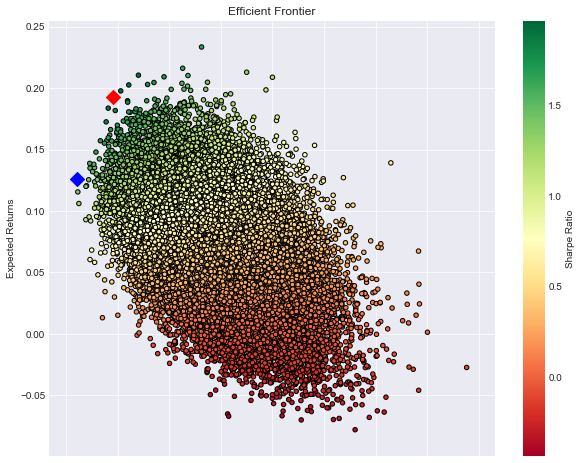

In [13]:
# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df_m.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)

plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=100)
plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=100)
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

---
## Result
### HRP

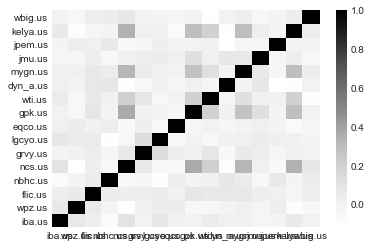

/Users/MikeW/miniconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


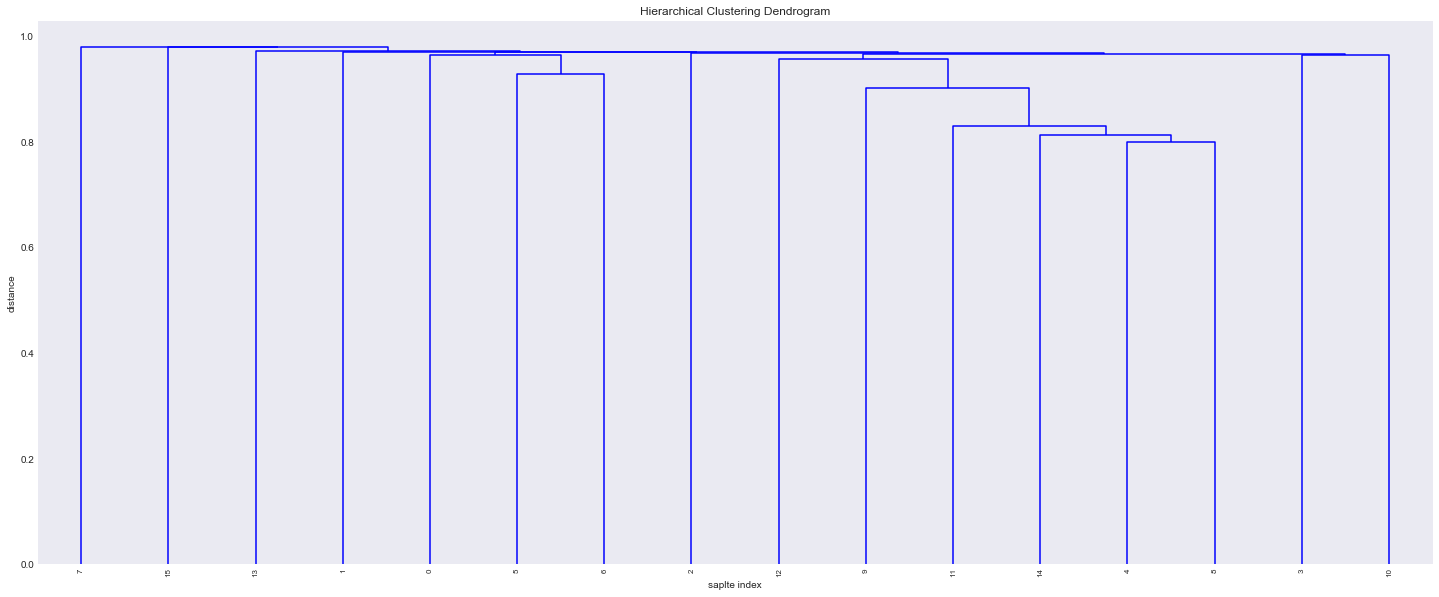

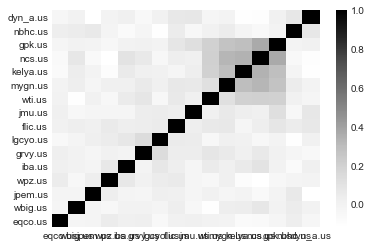

In [14]:
hrp, corr = main()

In [15]:
hrp.sum()

1.0

In [16]:
def anualized(row):
    anual = 1
    for i in row.values:
        anual = (anual)*(i+1)
    anual -= 1
    return anual

In [17]:
(df.apply(axis=0, func=anualized)*hrp).sum()

0.038958876484804825

---
### Markowitz

In [18]:
sharpe_portfolio

,Returns,Volatility,Sharpe Ratio,iba.us Weight,wpz.us Weight,flic.us Weight,nbhc.us Weight,ncs.us Weight,grvy.us Weight,lgcyo.us Weight,eqco.us Weight,gpk.us Weight,wti.us Weight,dyn_a.us Weight,mygn.us Weight,jmu.us Weight,jpem.us Weight,kelya.us Weight,wbig.us Weight
17643,0.192366,0.097866,1.965605,0.08092,0.137562,0.059971,0.017243,0.126056,0.018301,0.016837,0.143918,0.013519,0.038998,0.027559,0.11551,0.004927,0.135736,0.061439,0.001504


In [19]:
min_variance_port

,Returns,Volatility,Sharpe Ratio,iba.us Weight,wpz.us Weight,flic.us Weight,nbhc.us Weight,ncs.us Weight,grvy.us Weight,lgcyo.us Weight,eqco.us Weight,gpk.us Weight,wti.us Weight,dyn_a.us Weight,mygn.us Weight,jmu.us Weight,jpem.us Weight,kelya.us Weight,wbig.us Weight
38760,0.12622,0.080559,1.566796,0.091151,0.087159,0.041876,0.122983,0.041555,0.001319,0.01639,0.121708,0.004874,0.088185,0.015334,0.030693,0.026212,0.081527,0.108663,0.120371


---
## Creating db

In [48]:
#record = pd.DataFrame(columns=["n_assets", "assets", "w", "return", "sharpe_ratio", "volatility", "timestamp","type"])
#record = pickle.load(open("records.p"))
record = pd.read_csv("records.csv")
timestamp = time.time()

In [21]:
record = record.append({"n_assets":df.shape[1],"assets":hrp.index.tolist(),"w":hrp.values.tolist(),"sharpe_ratio":np.nan,"volatility":np.dot(df.std(),hrp),"return":(df.apply(axis=0, func=anualized)*hrp).sum(), "timestamp":timestamp, "type":"hrp"}, ignore_index=True)
record = record.append({"n_assets":df.shape[1],"assets":df.columns.tolist(),"w":min_variance_port.iloc[0,3:].values,"sharpe_ratio":min_variance_port.iloc[0,2],"volatility":min_variance_port.iloc[0,1],"return":min_variance_port.iloc[0,0], "timestamp":timestamp, "type":"min_variance"}, ignore_index=True)
record = record.append({"n_assets":df.shape[1],"assets":df.columns.tolist(),"w":sharpe_portfolio.iloc[0,3:].values,"sharpe_ratio":sharpe_portfolio.iloc[0,2],"volatility":sharpe_portfolio.iloc[0,1],"return":sharpe_portfolio.iloc[0,0], "timestamp":timestamp, "type":"best_sharpe"}, ignore_index=True)


In [49]:
record

,Unnamed: 0,n_assets,assets,w,return,sharpe_ratio,volatility,timestamp,type
0,0,8,"['nbhc.us', 'eqco.us', 'flic.us', 'wpz.us', 'g...","[0.19712334429455383, 0.41659884632165345, 0.1...",0.223870,NaN,0.018601,1.524321e+09,hrp
1,1,8,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.0388779 0.06273776 0.14136911 0.25051299 0...,0.096004,1.116585,0.085980,1.524321e+09,min_variance
2,2,8,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.27606476 0.29369718 0.06979937 0.03450592 0...,0.313080,2.544392,0.123047,1.524321e+09,best_sharpe
3,3,33,"['wbig.us', 'eqco.us', 'enrj.us', 'grvy.us', '...","[0.35211220995936676, 0.17859701579614048, 0.0...",0.076137,NaN,0.022028,1.524321e+09,hrp
4,4,33,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.06209831 0.05855317 0.04646619 0.05461156 0...,0.221070,2.445023,0.090416,1.524321e+09,min_variance
5,5,33,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.04101042 0.02923081 0.03905614 0.05129613 0...,0.556032,4.475924,0.124227,1.524321e+09,best_sharpe
6,6,76,"['jmu.us', 'agn_a.us', 'cma-ws.us', 'eim.us', ...","[0.001633930388741984, 0.01844720313421777, 0....",0.113082,NaN,0.031195,1.524322e+09,hrp
7,7,76,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.02302481 0.02464466 0.01823944 0.00623171 0...,0.187794,2.828110,0.066403,1.524322e+09,min_variance
8,8,76,"['iba.us', 'wpz.us', 'flic.us', 'nbhc.us', 'nc...",[0.02626972 0.0081671 0.01577057 0.00599947 0...,0.426996,5.212175,0.081923,1.524322e+09,best_sharpe
9,9,8,"['nbhc.us', 'eqco.us', 'flic.us', 'wpz.us', 'g...","[0.19712334429455383, 0.41659884632165345, 0.1...",0.223870,NaN,0.018601,1.524337e+09,hrp


---
## Exporting

In [47]:
#pickle.dump(record, open("records.p",'wb'))
record.to_csv("records.csv")
pickle.dump(hrp, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_hrp.p", 'wb'))
pickle.dump(df, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_df.p", 'wb'))
pickle.dump(corr, open("outputs/" + str(timestamp) + "_" + str(df.shape[0]) + "stocks_corr.p", 'wb'))